# **Python script to classify 5 different classes of Cardiac disorders using RQA Measures of latent space embeddings of Recurrence plots**

### Input : path to the Recurrence Plots.

### Output : Classification using RQA Values by a stacked classifier.

In [61]:

#Import necessary libraries

import numpy as np
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
from PIL import Image
from sklearn.manifold import TSNE
import math
from sklearn.svm import SVC
from skimage.measure import label, regionprops
import cv2
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import RUSBoostClassifier

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.models as models
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor
from torchvision import transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchinfo import summary
from torchmetrics.image import StructuralSimilarityIndexMeasure

# Hyperparameters/ Config
### Fine tune the hyperparameters based on your problem statement

In [62]:
PRETRAINED = False
ROIS=15
SEED = 6
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.20
OPTIMIZER = 'Adam'
DATASET_PATH = "\path to Recurrence plots folder" 
PRETRAINED_MODEL_PATH = '\path to rqa_autoencoder.pt' 
NUM_EPOCHS = 400
EMBEDDING_CHANNELS = 1

### Function To compare the orginal image with the reconstructed image

In [63]:
def show(data1, data2):
    '''function to visually compare the reconstructed image with the input images
    Each subject is represented by 2 rows and each pair of column corresponds to a ROI
    We can centre Crop the images before feeding to the Autoencoder (Custom Dataset)to get rid of the yellow border ,,
    '''

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for i in range(0, 2):
        for j in range(0, 10, 2):
            ax1 = axes[i][j]
            channel1 = data1[i * 5 + j]
            ax1.imshow(channel1, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax1.axis('off')
            ax1.set_title('original')

            ax2 = axes[i][j + 1]
            channel2 = data2[i * 5 + (j // 2)]
            ax2.imshow(channel2, cmap='viridis', vmin=-1, vmax=1)  # Specify vmin and vmax for the [0, 1] range
            ax2.axis('off')
            ax2.set_title('reconstructed')

    plt.show()

### To merge all 15 channels into $15\times 224\times224$ tensor

In [64]:
class AutoEncoderDataset(Dataset):
    '''
    input: path to all the recurrence plots
    ouput: a mutli-channel tensor with channels corresponding to ROIs of a brain network
    Dataset class AutoEncoderDataset get's the resized recurrence and stacks the singel channel image to make the input as a multichannel image
    ROIi corresponds to ith channel in all datapoints
    '''
    def __init__(self, root_dir, in_num_channels, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.labels = []
        self.samples = []
        rois =["i","ii","iii","avr","avl","avf","v1","v2","v3","v4","v5","v6","vx","vy","vz"]
        for class_name in ['Healthy control', 'Myocardial infarction','Bundle branch block','Cardiomyopathy','Dysrhythmia']:
            class_dir = os.path.join(root_dir, class_name)


            for file_name in os.listdir(class_dir):
                if file_name.endswith("vz.png"):
                    paths = [os.path.join(class_dir, file_name.replace("vz.png", f"{rois[i]}.png")) for i in range(0,in_num_channels)]
                    if all(os.path.exists(path) for path in paths):
                        label = os.path.join(class_dir, file_name)
                        new_label = (label.split('/')[-2],label.split('/')[-1][:8])
                        self.samples.append((paths, new_label))
                        self.labels.append(new_label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        paths, label = self.samples[idx]
        images = []

        for path in paths:
            image = Image.open(path)
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.CenterCrop((225,224)),
                transforms.Lambda(lambda img: img.crop((0, 0, img.width, img.height - 1))),
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
            image_tensor = transform(image)
            images.append(image_tensor)

        combined_image = torch.stack(images, dim=1).squeeze()

        if self.transform:
            image = self.transform(combined_image)
        else:
            image = combined_image
        return image, label

### CNN based AUTOENCODER MODEL

In [65]:
class Autoencoder(nn.Module):
    '''autoencoder architecture'''
    def __init__(self, rois, emb_channels):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # rois x 224 x 224
            nn.Conv2d(rois, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # 64 x 112 x 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            # 128 x 56 x 56
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            # 256 x 28 x 28
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            # 512 x 28 x 28
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, emb_channels, kernel_size=3, padding=1),
            nn.ReLU(),
#             nn.BatchNorm2d(emb_channels),
            nn.Dropout(0.25),
        )

        self.decoder = nn.Sequential(
            # 1024 x 14 x 14
            nn.ConvTranspose2d(emb_channels, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # 512 x 28 x 28
            nn.ConvTranspose2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # 256 x 28 x 28
            nn.ConvTranspose2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # 128 x 56 x 56
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # 64 x 112 x 112
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, rois, kernel_size=3, stride=2, padding=1, output_padding=1),
        )


    def forward(self, x):
        x = self.encoder(x)
        bottleneck_output = self.bottleneck(x)
        x = self.decoder(bottleneck_output)
        return x, bottleneck_output

### AUTOENCODER MODEL Summary

In [66]:
autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
summary(autoencoder_model, input_size=(BATCH_SIZE,ROIS,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [16, 15, 224, 224]        --
├─Sequential: 1-1                        [16, 1024, 14, 14]        --
│    └─Conv2d: 2-1                       [16, 64, 224, 224]        8,704
│    └─ReLU: 2-2                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-3                  [16, 64, 224, 224]        128
│    └─Conv2d: 2-4                       [16, 64, 224, 224]        36,928
│    └─ReLU: 2-5                         [16, 64, 224, 224]        --
│    └─BatchNorm2d: 2-6                  [16, 64, 224, 224]        128
│    └─MaxPool2d: 2-7                    [16, 64, 112, 112]        --
│    └─Conv2d: 2-8                       [16, 128, 112, 112]       73,856
│    └─ReLU: 2-9                         [16, 128, 112, 112]       --
│    └─BatchNorm2d: 2-10                 [16, 128, 112, 112]       256
│    └─Conv2d: 2-11                      [16, 128, 112, 112]       147,

### * Training and testing dateset creation
### * Autoencoder model training

In [67]:
torch.manual_seed(SEED)

#%%%%%%%%%%%%%%%%%%%%%%%     DATASET CREATION   %%%%%%%%%%%%%%%%%%%%%%%
dataset = AutoEncoderDataset(root_dir=DATASET_PATH, in_num_channels=ROIS)
test_size = int(len(dataset) * TRAIN_TEST_SPLIT)
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE) # set aside test data in the initial part
data_dl = DataLoader(dataset, batch_size=BATCH_SIZE)
if PRETRAINED :
    #%%%%%%%%%%%%%%%%%%%%%%%     PRE TRAINED MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    # device = torch.device("cuda" if torch.cuda.is_built() else "cpu") # on windows/ linux
    device = 'cuda' # on macOS
    autoencoder_model = autoencoder_model.to(device)
    state_dict = torch.load(PRETRAINED_MODEL_PATH)
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = value

    autoencoder_model.load_state_dict(new_state_dict)
    autoencoder_model = DataParallel(autoencoder_model)
    criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    criterion_mle = nn.MSELoss()
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9) # change the hyperparamertes if you are using SGD
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
else :
    # #%%%%%%%%%%%%%%%%%%%%%%%     MODEL   %%%%%%%%%%%%%%%%%%%%%%%
    autoencoder_model = Autoencoder(ROIS, EMBEDDING_CHANNELS)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    criterion_mle = nn.MSELoss()
    autoencoder_model = autoencoder_model.to(device)
    autoencoder_model = DataParallel(autoencoder_model)
    if OPTIMIZER == 'SGD':
        optimizer = optim.SGD(autoencoder_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    elif OPTIMIZER == 'Adam':
        optimizer = optim.Adam(autoencoder_model.parameters(), lr=LEARNING_RATE)
    #%%%%%%%%%%%%%%%%%%%%%%%     MODEL TRAINING   %%%%%%%%%%%%%%%%%%%%%%%
    train_losses = []
    val_losses = []

    for epoch in range(NUM_EPOCHS):
        autoencoder_model.train()
        train_loss = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = autoencoder_model(inputs)
            loss_ssim = 1- criterion(outputs[0], inputs)
            loss_mle = criterion_mle(outputs[0],inputs)
            loss = loss_mle+loss_ssim
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            criterion.update(outputs[0],inputs)

        autoencoder_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_dl:
                inputs = inputs.to(device)
                outputs = autoencoder_model(inputs)
                loss_ssim = 1-criterion(outputs[0], inputs)
                loss_mle = criterion_mle(outputs[0],inputs)
                loss = loss_mle+loss_ssim
                val_loss += loss.item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.5f} Val Loss: {val_loss:.5f}")
        

    torch.save(autoencoder_model.state_dict(), f'autoencoder_rqa.pt')

Epoch [1/400]: Train Loss: 11.44581 Val Loss: 3.40077
Epoch [2/400]: Train Loss: 10.19885 Val Loss: 3.30524
Epoch [3/400]: Train Loss: 9.92687 Val Loss: 3.50218
Epoch [4/400]: Train Loss: 9.74504 Val Loss: 3.22611
Epoch [5/400]: Train Loss: 9.55885 Val Loss: 3.15954
Epoch [6/400]: Train Loss: 9.35351 Val Loss: 3.13096
Epoch [7/400]: Train Loss: 9.11806 Val Loss: 3.08894
Epoch [8/400]: Train Loss: 8.89488 Val Loss: 3.01509
Epoch [9/400]: Train Loss: 8.67229 Val Loss: 2.91146
Epoch [10/400]: Train Loss: 8.46013 Val Loss: 2.87237
Epoch [11/400]: Train Loss: 8.32129 Val Loss: 2.81863
Epoch [12/400]: Train Loss: 8.18961 Val Loss: 2.76278
Epoch [13/400]: Train Loss: 7.96780 Val Loss: 2.68473
Epoch [14/400]: Train Loss: 7.77983 Val Loss: 2.67185
Epoch [15/400]: Train Loss: 7.73556 Val Loss: 2.82821
Epoch [16/400]: Train Loss: 7.69755 Val Loss: 2.65795
Epoch [17/400]: Train Loss: 7.59314 Val Loss: 2.62925
Epoch [18/400]: Train Loss: 7.48768 Val Loss: 2.55359
Epoch [19/400]: Train Loss: 7.41330

### Comparing orginal image to reconstructed ones

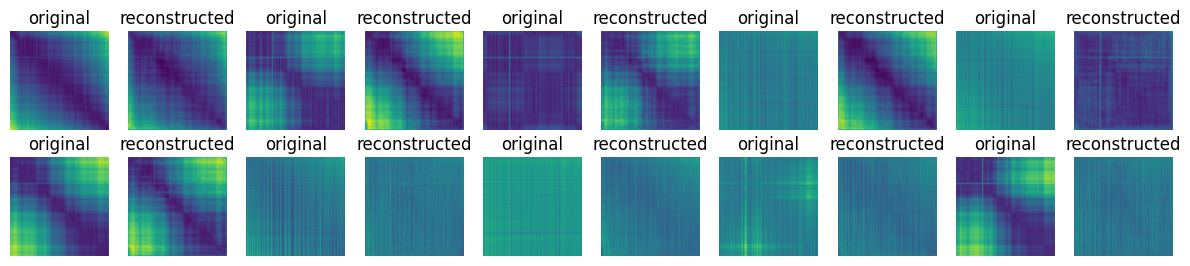

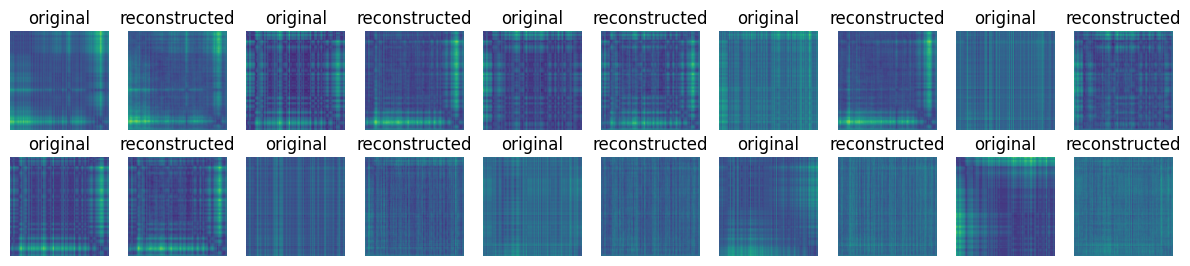

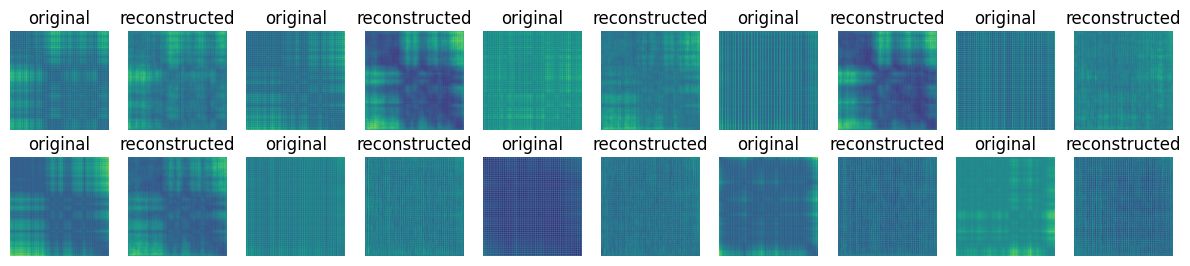

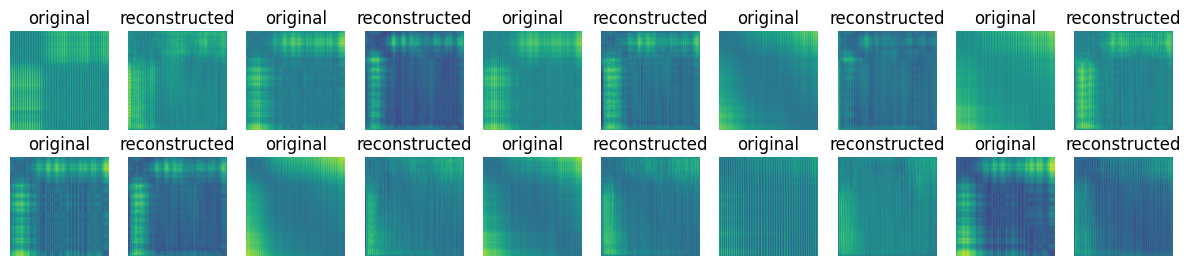

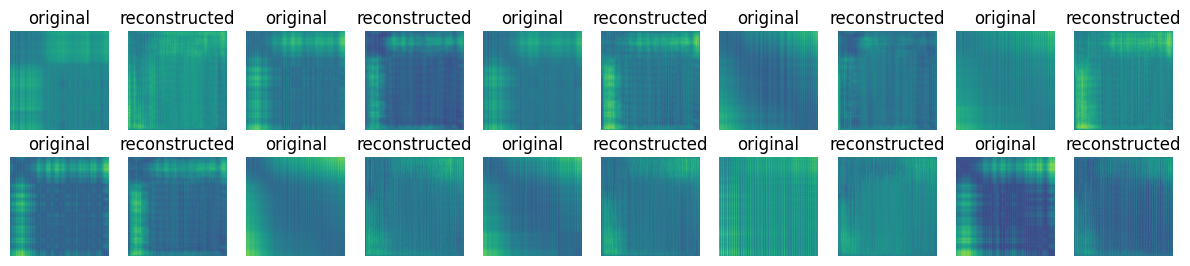

In [68]:
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        outputs = autoencoder_model(inputs)
        for k in range(5):
            show(inputs[k].to('cpu').numpy(), outputs[0][k].to('cpu').numpy())
        break

### Latent Space embeddings of whole dataset

In [69]:
embedded_dataset = {'Myocardial infarction':{}, 'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
subj_labels = []
with torch.no_grad():
    for inputs, labels in data_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            subj_labels.append(subj)
            embedded_dataset[class_][subj] = embedding[k].cpu().numpy()

### Latent Space embeddings of Training dataset

In [70]:
embedded_data = {'Myocardial infarction':{}, 'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in train_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            embedded_data[class_][subj] = embedding[k].cpu().numpy()

### Latent Space embeddings of Test dataset

In [71]:
embedded_data_test = {'Myocardial infarction':{},'Healthy control':{},'Bundle branch block':{},'Cardiomyopathy':{},'Dysrhythmia':{}}
autoencoder_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        _, embedding = autoencoder_model(inputs)
        for k, (class_, subj) in enumerate(zip(labels[0], labels[1])):
            embedded_data_test[class_][subj] = embedding[k].cpu().numpy()


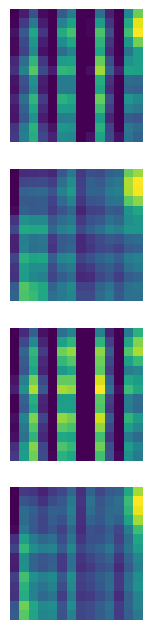

In [72]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Myocardial infarction'].keys())[i]
        plt.imshow(embedded_data['Myocardial infarction'][subj][channel])
        plt.axis('off')
plt.show()

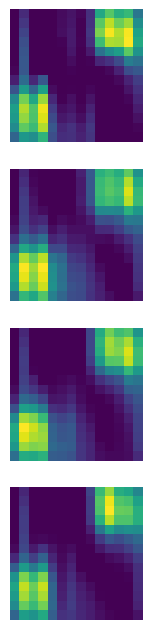

In [73]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Bundle branch block'].keys())[i]
        plt.imshow(embedded_data['Bundle branch block'][subj][channel])
        plt.axis('off')
plt.show()

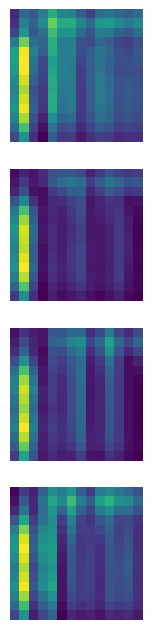

In [74]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Cardiomyopathy'].keys())[i]
        plt.imshow(embedded_data['Cardiomyopathy'][subj][channel])
        plt.axis('off')
plt.show()

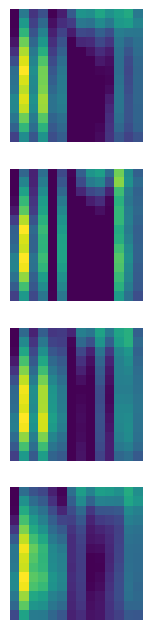

In [75]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Dysrhythmia'].keys())[i]
        plt.imshow(embedded_data['Dysrhythmia'][subj][channel])
        plt.axis('off')
plt.show()

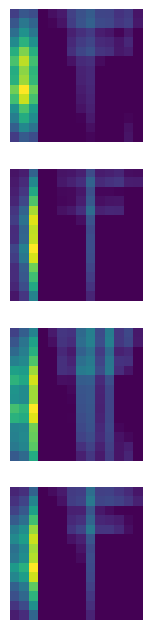

In [76]:
plt.figure(figsize=(6,10))
for i in range(1, 5*EMBEDDING_CHANNELS, EMBEDDING_CHANNELS):
    for channel in range(EMBEDDING_CHANNELS):
        plt.subplot(5, EMBEDDING_CHANNELS, i + channel)
        subj = list(embedded_data['Healthy control'].keys())[i]
        plt.imshow(embedded_data['Healthy control'][subj][channel])
        plt.axis('off')
plt.show()

### RQA feature extraction for Stacked Classifer

In [77]:
# The dataset class with recurrence Quantification Analysis (RQA) feature extraction
class EmbeddedDataset(Dataset):
    def __init__(self, class1_dict, class2_dict, class3_dict, class4_dict, class5_dict):
        self.class1_data = list(class1_dict.values())
        self.class2_data = list(class2_dict.values())
        self.class3_data = list(class3_dict.values())
        self.class4_data = list(class4_dict.values())
        self.class5_data = list(class5_dict.values())

        self.class1_labels = [0] * len(self.class1_data)
        self.class2_labels = [1] * len(self.class2_data)
        self.class3_labels = [2] * len(self.class3_data)
        self.class4_labels = [3] * len(self.class4_data)
        self.class5_labels = [4] * len(self.class5_data)

        self.data = self.class1_data + self.class2_data + self.class3_data + self.class4_data + self.class5_data
        self.labels = self.class1_labels + self.class2_labels + self.class3_labels + self.class4_labels + self.class5_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = torch.Tensor(self.data[index])
        label = self.labels[index]
        return data, label

    def get_rqa_features(self):
        rqa_features = []
        for data in self.data:
            # converting the tensor matrix to binary representation
            _, binary = cv2.threshold(data, 15, 1, cv2.THRESH_BINARY)
            N = data.shape[0]
            
            # Recurrence Rate (RR) 
            sum_binary = np.sum(binary)
            total_elements = N * N
            RR = sum_binary / total_elements if total_elements != 0 else 0
            
            # Determinism (DET)
            labeled_diagonals = label(binary, connectivity=2)
            diagonal_lengths = [region.area for region in regionprops(labeled_diagonals) if region.area > 1]
            DET = np.sum(diagonal_lengths) / sum_binary if sum_binary != 0 else 0
            
            # Averaged diagonal line length(L) 
            # Longest diagonal line(L_max)
            # Entropy (ENT)
            if diagonal_lengths:
                L = np.mean(diagonal_lengths)
                L_max = np.max(diagonal_lengths)
                hist, _ = np.histogram(diagonal_lengths, bins=range(1, int(L_max) + 2))
                prob = hist / np.sum(hist) if np.sum(hist) != 0 else np.zeros_like(hist)
                ENT = -np.sum(prob * np.log(prob + np.finfo(float).eps))
            else:
                L = 0
                L_max = 0
                ENT = 0
            
            # Laminarity (LAM)
            labeled_verticals = label(binary, connectivity=1)
            vertical_lengths = [region.area for region in regionprops(labeled_verticals) if region.area > 1]
            LAM = np.sum(vertical_lengths) / sum_binary if sum_binary != 0 else 0
            
            # Trapping time(TT) 
            # Longest vertical line(V_max)
            TT = np.mean(vertical_lengths) if vertical_lengths else 0
            V_max = np.max(vertical_lengths) if vertical_lengths else 0
            
            # Divergence (DIV)
            # Ratio(RATIO)
            DIV = 1 / L_max if L_max != 0 else 0
            RATIO = DET / RR if RR != 0 else 0
            
            features = [RR, DET, L, L_max, ENT, LAM, TT, V_max, DIV, RATIO]
            rqa_features.append(features)
        
        return np.array(rqa_features), np.array(self.labels)

In [78]:
emb_dataset = EmbeddedDataset(
    embedded_dataset['Healthy control'],
    embedded_dataset['Myocardial infarction'],
    embedded_dataset['Bundle branch block'],
    embedded_dataset['Cardiomyopathy'],
    embedded_dataset['Dysrhythmia'])

emb_data = EmbeddedDataset(
    embedded_data['Healthy control'],
    embedded_data['Myocardial infarction'],
    embedded_data['Bundle branch block'],
    embedded_data['Cardiomyopathy'],
    embedded_data['Dysrhythmia']
)

emb_data_test = EmbeddedDataset(
    embedded_data_test['Healthy control'],
    embedded_data_test['Myocardial infarction'],
    embedded_data_test['Bundle branch block'],
    embedded_data_test['Cardiomyopathy'],
    embedded_data_test['Dysrhythmia']
)


## Stacked classifier consisting of SVM,XGBOOST and RUSboost
### *  Confusion Matrix
### * Classification Report

Training Accuracy:  0.9558823529411765
Test Accuracy:  0.9705882352941176


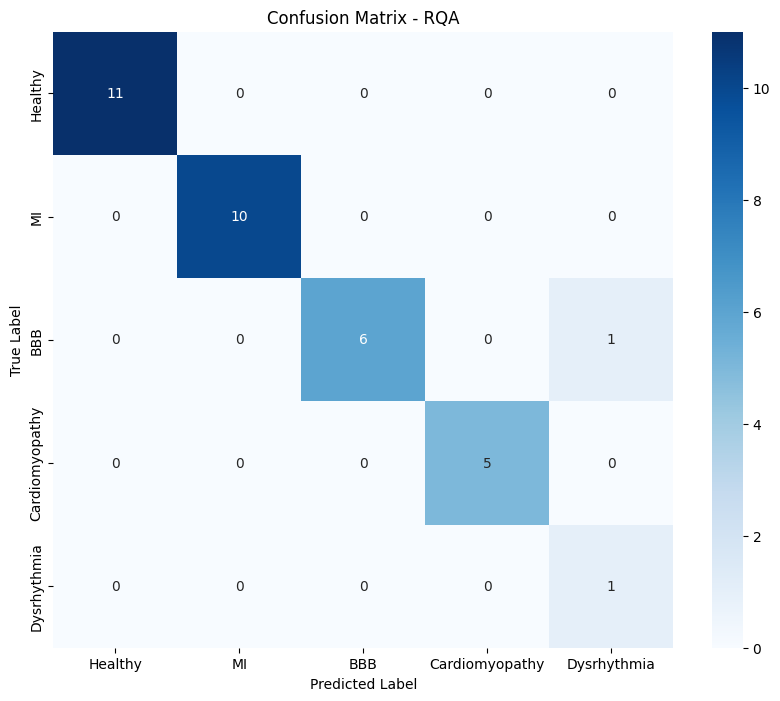

                       precision    recall  f1-score   support

              Control       1.00      1.00      1.00        11
Myocardial infarction       1.00      1.00      1.00        10
  Bundle branch block       1.00      0.86      0.92         7
       Cardiomyopathy       1.00      1.00      1.00         5
          Dysrhythmia       0.50      1.00      0.67         1

             accuracy                           0.97        34
            macro avg       0.90      0.97      0.92        34
         weighted avg       0.99      0.97      0.97        34



In [82]:
# RQA features for training, test and whole datasets
train_rqa_features, train_labels = emb_data.get_rqa_features()
test_rqa_features, test_labels = emb_data_test.get_rqa_features()
data_rqa_features, data_labels = emb_dataset.get_rqa_features()

# base models
base_models = [
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('svc', SVC(probability=True, kernel='rbf')),  # Using linear kernel SVM
    ('rusboost', RUSBoostClassifier(n_estimators=50)) ]

# meta-model
meta_model = LogisticRegression()

# Create the Stacking Classifier
stacked_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacked classifier
stacked_classifier.fit(train_rqa_features, train_labels)

# Classifier on training and test datasets
train_predictions = stacked_classifier.predict(train_rqa_features)
test_predictions = stacked_classifier.predict(test_rqa_features)

# accuracy score
print("Training Accuracy: ", accuracy_score(train_labels, train_predictions))
print("Test Accuracy: ", accuracy_score(test_labels, test_predictions))

# Confusion Matrix
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia'], yticklabels=['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - RQA")
plt.savefig('Confusion Matrix - RQA.png', dpi=300)
plt.show()

# Classification Report
target_names = ['Control', 'Myocardial infarction', 'Bundle branch block', 'Cardiomyopathy', 'Dysrhythmia']
print(classification_report(test_labels, test_predictions, target_names=target_names))


### t-SNE Plot

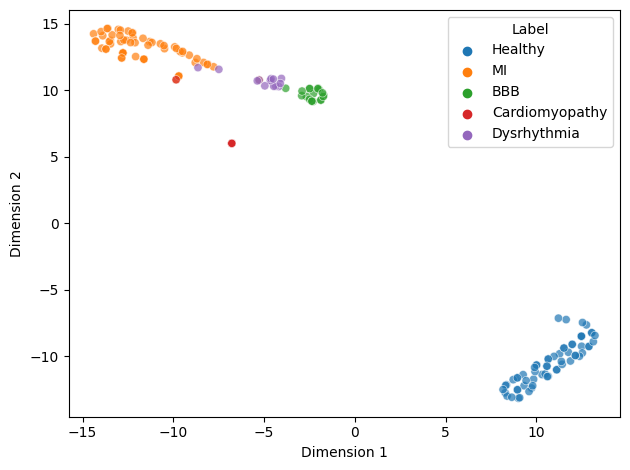

In [80]:
# List of diseases
disease_names = ['Healthy', 'MI', 'BBB', 'Cardiomyopathy', 'Dysrhythmia']
# Custom colours for plotting
custom_palette = {
    'Healthy': '#1f77b4',  # Blue
    'MI': '#ff7f0e',      # Orange
    'BBB': '#2ca02c',     # Green
    'Cardiomyopathy': '#d62728',  # Red
    'Dysrhythmia': '#9467bd'      # Purple
}

# Predictions (probabilities) for whole datasets
data_predictions_probability = stacked_classifier.predict_proba(data_rqa_features)

def map_labels_to_disease_names(labels):
    '''This Function returns the disease names form its corresponding numeric label '''
    return [disease_names[label] for label in labels]

def plot_tsne(probability, labels, title):
    '''This function plots the t-SNE plots using pediction probability'''
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(probability)
    
    # Map labels to disease names
    label_names = map_labels_to_disease_names(labels)
    
    # DataFrame for plotting
    df = pd.DataFrame({'Dimension 1': tsne_results[:, 0], 
                       'Dimension 2': tsne_results[:, 1], 
                       'Label': label_names})
    
    sns.scatterplot(data=df, x='Dimension 1', y='Dimension 2', hue='Label', palette = custom_palette, alpha=0.7)
    plt.savefig(f'{title}.png', dpi=300)
    plt.tight_layout()
    plt.show()
    
# t-SNE Plot for dataset
plot_tsne(data_predictions_probability, data_labels, 't-SNE - Dataset Predictions')

